In [1]:
from datetime import datetime
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pandas as pd
from pandas.tseries.offsets import DateOffset
import numpy as np
import re
from tqdm import tqdm

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import r2_score

In [2]:
acled = pd.read_json('acled.json')
india_acled = acled[acled['COUNTRY'] == 'India']
india_acled['EVENT_DATE'] = pd.to_datetime(india_acled['EVENT_DATE'].astype(str), format='%Y%m%d')
india_demonstrations = india_acled[(india_acled['EVENT_TYPE'] == 'Protests') | (india_acled['EVENT_TYPE'] == 'Riots')]

C:\Users\JIANFU~1\AppData\Local\Temp/ipykernel_12888/7909199.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  india_acled['EVENT_DATE'] = pd.to_datetime(india_acled['EVENT_DATE'].astype(str), format='%Y%m%d')


In [3]:
demonstration_count_daily = india_demonstrations.groupby(pd.Grouper(key = 'EVENT_DATE', freq = 'D')).count()
demonstration_count_daily = demonstration_count_daily[['ACTOR1']]
demonstration_count_daily.columns = ['y']

In [4]:
demonstration_count_weekly_rolling = (demonstration_count_daily.reset_index().iloc[::-1]).rolling(7, on= 'EVENT_DATE').sum().iloc[::-1]
demonstration_count_weekly_rolling.index = demonstration_count_weekly_rolling['EVENT_DATE'] 
demonstration_count_weekly_rolling = demonstration_count_weekly_rolling.drop(columns = 'EVENT_DATE')

In [5]:
demonstration_count_weekly_rolling

,y
EVENT_DATE,
2016-01-01,157.0
2016-01-02,168.0
2016-01-03,168.0
2016-01-04,178.0
2016-01-05,166.0
...,...
2020-10-20,NaN
2020-10-21,NaN
2020-10-22,NaN


In [6]:
demonstration_count_daily.head(10)

,y
EVENT_DATE,
2016-01-01,15
2016-01-02,21
2016-01-03,17
2016-01-04,29
2016-01-05,33
2016-01-06,25
2016-01-07,17
2016-01-08,26
2016-01-09,21


In [7]:
india = pd.read_json('../Data/india-news-headlines_IN_features_extracted.json')
india['total articles'] = 1
india['negative articles'] = india['SA tag'].map({'POSITIVE': 0, 'NEGATIVE': 1})
india['positive articles'] = india['SA tag'].map({'POSITIVE': 1, 'NEGATIVE': 0})
india['date'] = pd.to_datetime(india['date'])

In [8]:
india.head()

,date,headline_category,title,geoparsed,cities_list,states_list,countries_list,country_name,country_code,news tag,news tag confidence,SA tag,SA tag confidence,total articles,negative articles,positive articles
0,2011-01-01,speak-out,Do you agree that the increase in fine from Rs...,"{'milliseconds': 2, 'language': 'EN', 'version...","[{'score': 1, 'featureCode': 'PPL', 'stateGeoN...","[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Republic of India,IN,Business,0.803377,NEGATIVE,0.969205,1,1,0
1,2011-01-01,unknown,India ready to make history: Dhoni,"{'milliseconds': 1, 'language': 'EN', 'version...",[],[],"[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Republic of India,IN,World,0.994686,POSITIVE,0.998286,1,0,1
2,2011-01-01,unknown,All-religion centre planned in Bangalore,"{'milliseconds': 1, 'language': 'EN', 'version...","[{'score': 1, 'featureCode': 'PPLA', 'stateGeo...","[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Republic of India,IN,World,0.986057,POSITIVE,0.996107,1,0,1
3,2011-01-01,world.pakistan,India; Pakistan exchange lists of nuclear inst...,"{'milliseconds': 2, 'language': 'EN', 'version...",[],[],"[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Republic of India,IN,World,0.991070,POSITIVE,0.992906,1,0,1
4,2011-01-01,unknown,India eye historic series triumph in SA,"{'milliseconds': 1, 'language': 'EN', 'version...",[],[],"[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Republic of India,IN,World,0.991931,POSITIVE,0.998448,1,0,1


In [9]:
india_weekly_rolling = india.groupby(['news tag', pd.Grouper(key = 'date', freq = 'D')]).sum()
world_weekly_rolling =  india_weekly_rolling.loc['World'].reset_index().rolling(7, on= 'date').sum()
world_weekly_rolling['Sentiment Index'] = world_weekly_rolling['negative articles'] / world_weekly_rolling['total articles']
world_weekly_rolling['Sentiment Index'].fillna(0)
world_weekly_rolling.index = world_weekly_rolling['date'] + DateOffset(days = 1)
world_weekly_rolling=world_weekly_rolling.drop(columns='date')

In [10]:
world_weekly_rolling.head()

,SA tag confidence,negative articles,news tag confidence,positive articles,total articles,Sentiment Index
date,,,,,,
2011-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-06,NaN,NaN,NaN,NaN,NaN,NaN


# D-7 Exploration (Rolling past 7 days articles sum and Sum of upcoming week of events)

In [11]:
world_weekly_rolling

,SA tag confidence,negative articles,news tag confidence,positive articles,total articles,Sentiment Index
date,,,,,,
2011-01-02,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-03,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-04,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-05,NaN,NaN,NaN,NaN,NaN,NaN
2011-01-06,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2020-12-28,862.443655,526.0,792.353321,345.0,871.0,0.603904
2020-12-29,853.518647,524.0,785.990803,338.0,862.0,0.607889
2020-12-30,848.622243,505.0,780.734210,352.0,857.0,0.589265


In [12]:
d7_offset_rolling2 = pd.merge(world_weekly_rolling, demonstration_count_weekly_rolling, left_index = True, right_index = True)

In [13]:
d7_offset_rolling2 = d7_offset_rolling2.dropna()

In [14]:
d7_offset_rolling2

,SA tag confidence,negative articles,news tag confidence,positive articles,total articles,Sentiment Index,y
2016-01-01,517.001128,248.0,481.070648,274.0,522.0,0.475096,157.0
2016-01-02,516.164749,243.0,482.573781,278.0,521.0,0.466411,168.0
2016-01-03,512.619048,250.0,478.905451,268.0,518.0,0.482625,168.0
2016-01-04,542.469814,272.0,508.587490,276.0,548.0,0.496350,178.0
2016-01-05,528.977623,270.0,498.643508,265.0,535.0,0.504673,166.0
...,...,...,...,...,...,...,...
2020-10-14,796.764620,475.0,739.020192,330.0,805.0,0.590062,327.0
2020-10-15,814.748659,486.0,756.239431,337.0,823.0,0.590522,319.0
2020-10-16,820.789295,487.0,761.174154,342.0,829.0,0.587455,285.0
2020-10-17,840.334237,529.0,776.553704,319.0,848.0,0.623821,268.0


In [15]:
X = d7_offset_rolling2['Sentiment Index'].values.reshape(-1, 1)
y = d7_offset_rolling2['y'].values

In [16]:
pred_df = pd.DataFrame(data = y, columns = ['true'])
pred_df_poly = pd.DataFrame(data = y, columns = ['true'])

In [17]:
kf = StratifiedKFold(n_splits=5)

lin = LinearRegression()
ridge = Ridge()
svr = SVR()
tree = DecisionTreeRegressor()
forest = RandomForestRegressor()

models = [lin, ridge, svr, tree, forest]

In [18]:
for model in models:
    predictions = {}
    for train_index, test_index in kf.split(X,y):
        model.fit(X[train_index], y[train_index])
        predictions.update(
                    {
                        x: y_pred
                        for x, y_pred in zip(
                            test_index,
                            model.predict(
                                X[test_index],
                            )
                        )
                    }
                )
    tmp_df = pd.DataFrame.from_dict({str(model) : predictions})
    pred_df = pd.concat([pred_df, tmp_df], axis = 1)

d:\venvs_hto\images\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
d:\venvs_hto\images\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
d:\venvs_hto\images\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
d:\venvs_hto\images\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
d:\venvs_hto\images\lib\site-packages\sklearn\model_selection\_s

Text(0.5, 1.0, 'Using Sentiment Index of articles to predict ACLED Demonstrations')

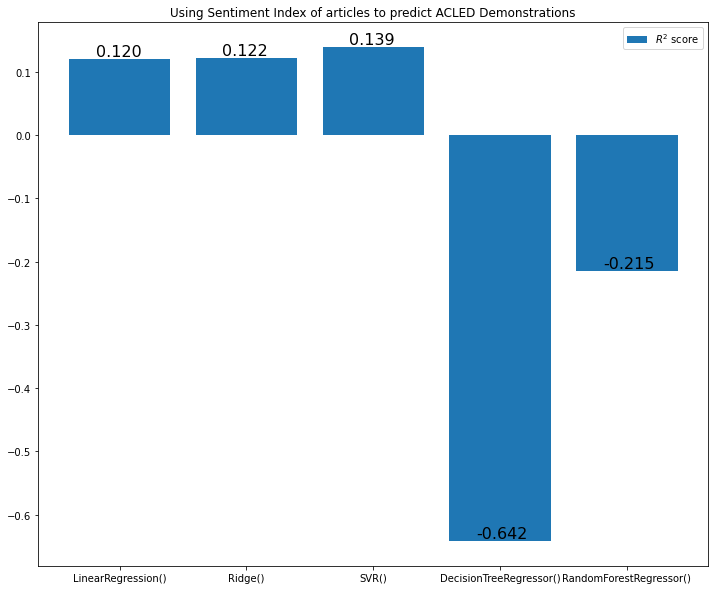

In [19]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.bar(
    x_bar := [str(model) for model in models],
    y_bar := [r2_score(pred_df["true"], pred_df[str(model)]) for model in x_bar],
    label="$R^2$ score"
)
for i, y_val in enumerate(y_bar):
    ax.text(i - 0.19, y_val + 0.005, f"{y_val:.03f}", fontsize=16)
ax.legend()
plt.title('Using Sentiment Index of articles to predict ACLED Demonstrations')

In [20]:
# Polynomial Regression

max_degree = 8
lin_models = dict.fromkeys(range(1,max_degree))
X_polys = dict.fromkeys(range(1,max_degree))

for i in range(1,max_degree):
    lin = LinearRegression()
    poly_reg = PolynomialFeatures(degree = i)
    X_poly = poly_reg.fit_transform(X)
    lin_models[i] = lin
    X_polys[i] = X_poly


In [21]:
for key in lin_models:
    predictions = {}
    model = lin_models[key]
    for train_index, test_index in kf.split(X_polys[key],y):
        model.fit(X_polys[key][train_index], y[train_index])
        predictions.update(
                    {
                        x: y_pred
                        for x, y_pred in zip(
                            test_index,
                            model.predict(
                                X_polys[key][test_index],
                            )
                        )
                    }
                )
    tmp_df = pd.DataFrame.from_dict({str(model) : predictions})
    pred_df_poly = pd.concat([pred_df_poly, tmp_df], axis = 1)

d:\venvs_hto\images\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
d:\venvs_hto\images\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
d:\venvs_hto\images\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
d:\venvs_hto\images\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
d:\venvs_hto\images\lib\site-packages\sklearn\model_selection\_s

Text(0.5, 1.0, 'Using Sentiment Index of articles to predict ACLED Demonstrations')

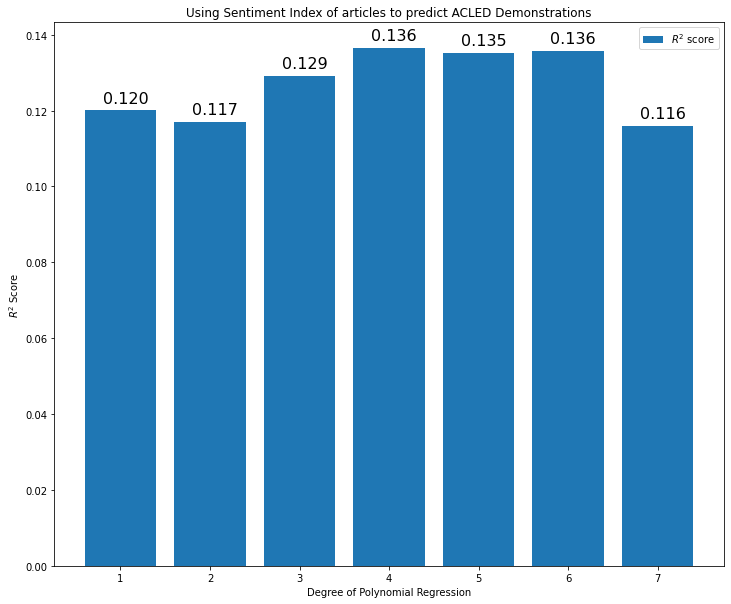

In [22]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.bar(
    x_bar := [i for i in range(1,max_degree)],
    y_bar := [r2_score(pred_df_poly["true"], pred_df_poly.iloc[:,i]) for i in x_bar],
    label="$R^2$ score",
)
for i, y_val in enumerate(y_bar):
    ax.text(i + 0.8, y_val + 0.002, f"{y_val:.03f}", fontsize=16)
ax.legend()
plt.xlabel('Degree of Polynomial Regression')
plt.ylabel('$R^2$ Score')
plt.title('Using Sentiment Index of articles to predict ACLED Demonstrations')